# Author: Sevendi Eldrige Rifki Poluan

In [1]:
!nvidia-smi

Sun May 14 16:37:04 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090         Off| 00000000:65:00.0 Off |                  N/A |
|  0%   43C    P8               37W / 390W|    243MiB / 24576MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!python3 -m pip install --upgrade pip
!pip install gym=0.26.2
!pip install pyvirtualdisplay 
!pip install pygame  

In [ ]:
!apt-get install -y xvfb ffmpeg

# Import the required libraries

In [1]:
import tensorflow as tf
import gym 
import numpy as np
from IPython.display import Image
import imageio 
from collections import deque
import random
import matplotlib.pyplot as plt

2023-05-15 01:38:40.557498: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-15 01:38:40.803390: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
gym.__version__

'0.26.2'

# Here is how it looks like before training (baseline)

In [2]:
# create the environment for the CartPole task
env = gym.make("CartPole-v1", render_mode='rgb_array') 

# resetting the environment to its initial state and obtaining the first observation/state
observation, _ = env.reset()
 
frames = [] 
terminated = False

# run the environment and record the freames (gif)
for x in range(50):
    
    # capture the frame
    frame = env.render()
    
    # store the frames
    frames.append(frame)
    
    # get the next state
    observation, reward, terminated, truncated, info = env.step(env.action_space.sample())

env.close()

/usr/local/lib/python3.8/dist-packages/gym/envs/classic_control/cartpole.py:177: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


In [3]:
# save the frames as GIF
imageio.mimsave("demo.gif", frames, duration=0.1)

#### In the CartPole-v0 environment, an episode ends when the pole of the cart-pole system tilts more than `15 degrees` from vertical or the cart moves more than 2.4 units from the center. The maximum number of time steps in each episode is 200. When an episode ends, the environment is automatically reset and a new episode begins.

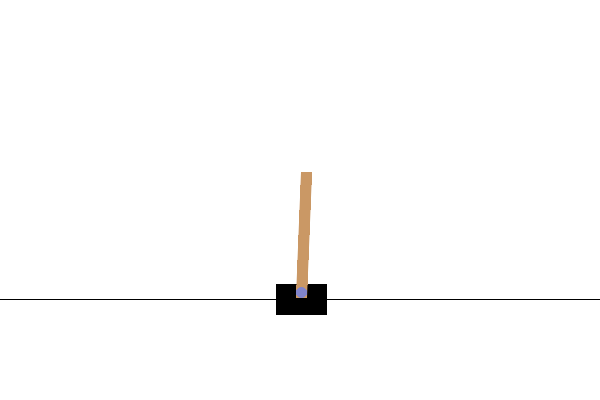

In [4]:
Image(filename="demo.gif")

# Create the agent

In [5]:
# allows for the same random events or processes to occur each time the code is run
seed = 20220
tf.random.set_seed(seed)
np.random.seed(seed)

In [37]:
class DQReinforcementLearning:
    
    def __init__(self, 
                 state_size, 
                 action_size,
                 batch_size = 128, # in this case lower batch size may lead to overfitting because it makes the model more sensitive to individual data points in the training set
                 gamma=0.99,
                 epsilon = 1.0,
                 epsilon_decay = 0.999,
                 epsilon_min = 0.01,
                 memory_size=1500,
                 start_training_after_memory_reach = 1000,
                 load_weights=False
        ):
  
        self.state_size = state_size
        self.action_size = action_size
        self.batch_size = batch_size
         
        self.gamma = gamma # discount factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min 
        self.memory = deque(maxlen=memory_size) # store the experience of the agent (replay buffer) - limit the size of the replay buffer and remove the oldest transitions once it reaches its maximum size. 
        self.start_training_after_memory_reach = start_training_after_memory_reach # ensure that the agent has collected enough experience before starting to train the neural network
         
        self.model = self.create_model() # create a neural network for reinforcement learning
        self.target_model = self.create_model() # i use a separate network to generate the target Q-values during training, rather than using the same network that is being updated. This can help stabilize the learning process by fixing the target values during each update.
        
        # load model if any saved weights available
        try:
            if load_weights:
                self.model.load_weights("model.weights.h5")
                print("Weights loaded ...")
        except Exception as e:
            print("Failed load weights", e)
          
    def create_model(self):
        inputs = tf.keras.layers.Input(shape=(self.state_size))   
        x = tf.keras.layers.Dense(64, activation='relu', kernel_initializer='RandomNormal')(inputs)
        x = tf.keras.layers.Dense(128, activation='relu', kernel_initializer='RandomNormal')(x) 
        x = tf.keras.layers.Dense(256, activation='relu', kernel_initializer='RandomNormal')(x) 
        
        # i used a linear activation function to allow for a wider range of possible outputs since the Q-values can be negative or positive
        outputs = tf.keras.layers.Dense(self.action_size, activation="linear")(x)

        model = tf.keras.Model(inputs, outputs) 
        model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)) 
        
        return model 
 
    def train(self):
        
        # waiting until the agent has enough experience in the replay buffer before starting training
        if len(self.memory) < self.start_training_after_memory_reach:
            return
        
        # sample a batch randomly from the agent's experience and use it for training.
        batch = random.sample(self.memory, self.batch_size) 
        
        # squeeze the additional dimension from our input data. 
        x_input = np.vstack(np.array(batch, dtype=object)[:, 0])
        x_target = np.vstack(np.array(batch, dtype=object)[:, 3])

        action = np.array(batch, dtype=object)[:, 1]
        reward = np.array(batch, dtype=object)[:, 2]
        done = np.array(batch, dtype=object)[:, 4]
        
        target = self.model.predict(x_input, verbose=0)
        target_val = self.target_model.predict(x_target, verbose=0) # to overcome the instability issue in deep Q-learning

        for i in range(self.batch_size):
            
            # if the termination status is true, assign a low reward to the corresponding action in our Q-table in the network
            if done[i]:
                target[i][action[i]] = reward[i]
            else:
                # Bellman equation
                # Q(s, a) = r + γ(max(Q(s', a')))
                target[i][action[i]] = reward[i] + self.gamma * (max(target_val[i]))

        history = self.model.fit(
            x_input, 
            target, 
            epochs=1,  
            verbose=0
        )
        return history
    
    def save(self): 
        self.model.save_weights("model.weights.h5")
        
    def get_policy(self, state, random_action=False):
        if np.random.rand() <= self.epsilon or random_action:
            return random.randrange(self.action_size)
        else:
            q_value = self.model.predict(tf.expand_dims(state, axis=0), verbose=0)
            return q_value.argmax()
 
    def add_experience(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay 
            
    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

# Train the agent

In [8]:
# create the environment for CartPole
env = gym.make('CartPole-v1')

# obtain the number of states available and actions for building the neural network in the CartPole environment
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

# create an agent instance for the CartPole
agent = DQReinforcementLearning(state_size, action_size)
 
EPISODES = 1000
rewards = []
losses = []
max_rewards = 0
random_action = False
count_200 = 0

for episode in range(EPISODES):
    
    # reset the state for every episode
    total_reward_per_episode = 0
    observation, _ = env.reset() 
    terminated = False 

    while not terminated: 
        
        action = agent.get_policy(observation, random_action=random_action)
        next_observation, reward, terminated, truncated, info = env.step(action)
        
        # add experience to the agent
        agent.add_experience(observation, action, reward if not terminated else -1, next_observation, terminated)
        
        # train the agent's model
        history = agent.train()
        loss = history.history["loss"][0] if history is not None else float("inf")
        losses.append(loss)
        
        # collect the total rewards obtained
        total_reward_per_episode += reward
        
        # update the state for the next prediction
        observation = next_observation.copy()
 
        # if the terminated status is true, it means that the episode has ended and the agent needs to start a new episode from the initial state
        if terminated or total_reward_per_episode == 200: # i just limit to only 200 rewards
             
            # collect the total rewards obtained
            rewards.append(total_reward_per_episode)  
            
            # i used this to prevent from the instability issue in deep Q-learning
            # because the Q-values and target values used to train the network are constantly changing as the network learns, which makes the environment non-stationary
            agent.update_target_model()
            
            print(f"EPISODE: {episode} REWARD: {total_reward_per_episode} MEMORY_USED: {len(agent.memory)} EPSILON: {agent.epsilon} LOSS: {loss}")
            
            terminated = True
    
    # saves the model weights whenever the number of rewards exceeds a certain threshold (max_rewards | total_reward_per_episode)
    if (max_rewards < total_reward_per_episode or total_reward_per_episode >= 200) and len(agent.memory) > agent.start_training_after_memory_reach:
        agent.save()
        print("-------------------------------------------- model improved: saved to model.weights.h5")
        
        max_rewards = max(max_rewards, total_reward_per_episode)
    
    # randomly selecting actions if the total rewards obtained during training are low
    if total_reward_per_episode < 20:
        random_action = True
    else:
        random_action = False
    
    # maintain to close all episodes when the last 10 rewards have 200 rewards 
    if total_reward_per_episode == 200: 
        count_200 +=1
    else: 
        count_200 = 0
    if count_200 == 7:
        agent.save()
        break
    
 

EPISODE: 0 REWARD: 20.0 MEMORY_USED: 20 EPSILON: 0.9801888648295347 LOSS: inf
EPISODE: 1 REWARD: 10.0 MEMORY_USED: 30 EPSILON: 0.9704309672630859 LOSS: inf
EPISODE: 2 REWARD: 17.0 MEMORY_USED: 47 EPSILON: 0.9540649618417361 LOSS: inf
EPISODE: 3 REWARD: 48.0 MEMORY_USED: 95 EPSILON: 0.9093297114626595 LOSS: inf
EPISODE: 4 REWARD: 35.0 MEMORY_USED: 130 EPSILON: 0.8780383184956015 LOSS: inf
EPISODE: 5 REWARD: 27.0 MEMORY_USED: 157 EPSILON: 0.8546369224228781 LOSS: inf
EPISODE: 6 REWARD: 48.0 MEMORY_USED: 205 EPSILON: 0.8145637636371417 LOSS: inf
EPISODE: 7 REWARD: 16.0 MEMORY_USED: 221 EPSILON: 0.8016280363938307 LOSS: inf
EPISODE: 8 REWARD: 20.0 MEMORY_USED: 241 EPSILON: 0.7857468750083979 LOSS: inf
EPISODE: 9 REWARD: 10.0 MEMORY_USED: 251 EPSILON: 0.7779246707428734 LOSS: inf
EPISODE: 10 REWARD: 16.0 MEMORY_USED: 267 EPSILON: 0.7655707927460921 LOSS: inf
EPISODE: 11 REWARD: 16.0 MEMORY_USED: 283 EPSILON: 0.7534131012276413 LOSS: inf
EPISODE: 12 REWARD: 11.0 MEMORY_USED: 294 EPSILON: 0.7

EPISODE: 84 REWARD: 116.0 MEMORY_USED: 1500 EPSILON: 0.009998671593271896 LOSS: 0.02047817036509514
EPISODE: 85 REWARD: 117.0 MEMORY_USED: 1500 EPSILON: 0.009998671593271896 LOSS: 0.0041207121685147285
EPISODE: 86 REWARD: 110.0 MEMORY_USED: 1500 EPSILON: 0.009998671593271896 LOSS: 0.009870092384517193
EPISODE: 87 REWARD: 114.0 MEMORY_USED: 1500 EPSILON: 0.009998671593271896 LOSS: 0.012324035167694092
EPISODE: 88 REWARD: 118.0 MEMORY_USED: 1500 EPSILON: 0.009998671593271896 LOSS: 0.00835251435637474
EPISODE: 89 REWARD: 125.0 MEMORY_USED: 1500 EPSILON: 0.009998671593271896 LOSS: 0.00666398648172617
EPISODE: 90 REWARD: 112.0 MEMORY_USED: 1500 EPSILON: 0.009998671593271896 LOSS: 0.006546937860548496
EPISODE: 91 REWARD: 117.0 MEMORY_USED: 1500 EPSILON: 0.009998671593271896 LOSS: 0.005448383279144764
EPISODE: 92 REWARD: 115.0 MEMORY_USED: 1500 EPSILON: 0.009998671593271896 LOSS: 0.00481174373999238
EPISODE: 93 REWARD: 114.0 MEMORY_USED: 1500 EPSILON: 0.009998671593271896 LOSS: 0.015030425041

EPISODE: 164 REWARD: 137.0 MEMORY_USED: 1500 EPSILON: 0.009998671593271896 LOSS: 0.047772787511348724
EPISODE: 165 REWARD: 137.0 MEMORY_USED: 1500 EPSILON: 0.009998671593271896 LOSS: 0.035236142575740814
EPISODE: 166 REWARD: 139.0 MEMORY_USED: 1500 EPSILON: 0.009998671593271896 LOSS: 0.0272489283233881
EPISODE: 167 REWARD: 149.0 MEMORY_USED: 1500 EPSILON: 0.009998671593271896 LOSS: 0.012983717024326324
EPISODE: 168 REWARD: 146.0 MEMORY_USED: 1500 EPSILON: 0.009998671593271896 LOSS: 0.039081260561943054
EPISODE: 169 REWARD: 95.0 MEMORY_USED: 1500 EPSILON: 0.009998671593271896 LOSS: 0.052664607763290405
EPISODE: 170 REWARD: 95.0 MEMORY_USED: 1500 EPSILON: 0.009998671593271896 LOSS: 0.08559045195579529
EPISODE: 171 REWARD: 14.0 MEMORY_USED: 1500 EPSILON: 0.009998671593271896 LOSS: 0.9142397046089172
EPISODE: 172 REWARD: 11.0 MEMORY_USED: 1500 EPSILON: 0.009998671593271896 LOSS: 0.6833760738372803
EPISODE: 173 REWARD: 35.0 MEMORY_USED: 1500 EPSILON: 0.009998671593271896 LOSS: 1.31931245326

# Plot the rewards and loss during training

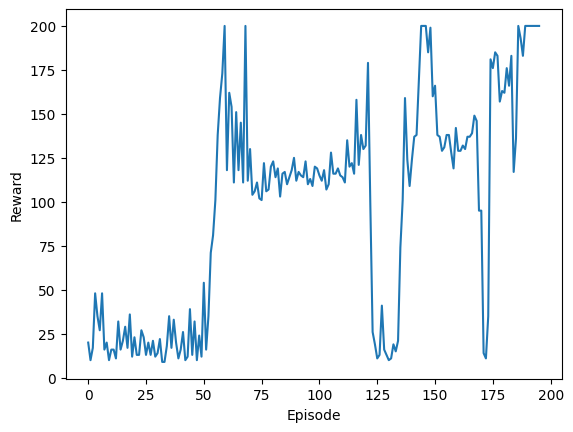

In [9]:
plt.figure()
plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

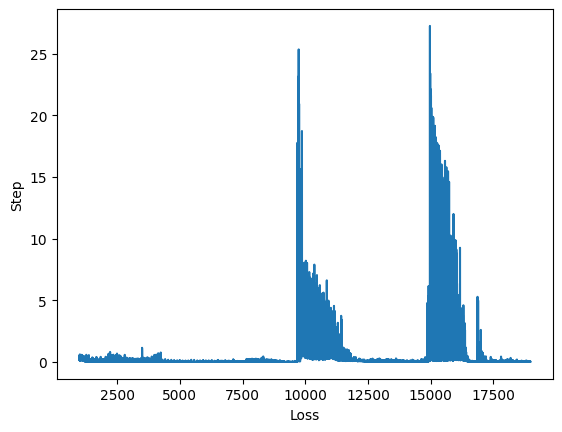

In [10]:
plt.figure()
plt.plot(losses)
plt.xlabel('Loss')
plt.ylabel('Step')
plt.show()

# Load the model

In [38]:
# create the environment for CartPole
env = gym.make('CartPole-v1', render_mode="rgb_array")

# obtain the number of states available and actions for building the neural network in the CartPole environment
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

# create an agent instance for the CartPole
agent = DQReinforcementLearning(state_size, action_size, load_weights=True)

Weights loaded ...


# Evaluate the trained model

In [47]:
# reset the environment and get the initial state
observation, _ = env.reset()
terminated = False

# store the frames
frames = []
count = 0

# run the environment 
while not terminated:
    
    # render the environment and capture the frame
    frame = env.render()
    
    # store the frames
    frames.append(frame)
    
    action = agent.model.predict(tf.expand_dims(observation, axis=0), verbose=0).argmax()
     
    # get the next state
    observation, reward, terminated, truncated, info = env.step(action) 
    
    if count == 200:
        terminated = True
    
    count += 1

env.close()

# save the frames as a GIF
imageio.mimsave("eval.gif", frames, duration=0.1)

# Evaluate with the model that is already trained

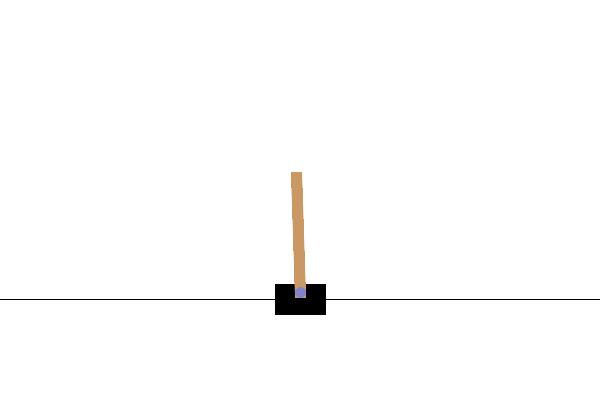

In [43]:
Image(filename="eval.gif")